# Try regression to forecast the price for some stock market blue chips on historical data from yahoo.finance.com

## Sources:
1. <a href="https://finance.yahoo.com/quote/AAPL/history?p=AAPL">Apple Inc. (AAPL)</a>
2. <a href="https://finance.yahoo.com/quote/GC%3DF/history?p=GC%3DF">Gold Dec 20 (GC=F)</a>
3. <a href="https://finance.yahoo.com/quote/CL%3DF/history?p=CL%3DF">ACrude Oil Dec 20 (CL=F)</a>

### Despite the Y2020 was slightly unusual for the prediction purposes, the trends and sycles have been catched more or less fine for Apple stocks and Gold prices. Crude oil price prediction has probably been failed, and one may presume that this domain market moves are visibly less natural then Apple and Gold market moves or crude oil data set covers too short time periode to catch the trends and cicles.

We can see that COVID19 related drop  in March 2020 has not been predicted, well this issue obfiously has not any market-based couses and could be forecasted on additional data based on human population, weather and so on.

Prediction on shortest periodes (quarter, month, week) looks better, but was less interesting for analysis.

In [1]:
import numpy as np
import pandas as pd

import datetime as dt
import holidays

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor


In [2]:
stock = 'gold'     #  'AAPL', 'crude_oil', 'gold'

df = pd.read_csv(stock + '.csv')
df.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0
3,2000-09-03,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-04,NaN,NaN,NaN,NaN,NaN,NaN
5,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0


In [3]:
# leave only 'Date', 'Close' from df and convert the columns names to lowercase

data = df[['Date', 'Close']]
data.columns = data.columns.str.lower()
data.head(6)

,date,close
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-03,NaN
4,2000-09-04,NaN
5,2000-09-05,275.799988


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
close,5110.0,998.778004,476.040165,255.100006,467.275001,1161.099976,1322.199951,2051.5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6188 entries, 0 to 6187
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6188 non-null   object 
 1   close   5110 non-null   float64
dtypes: float64(1), object(1)
memory usage: 96.8+ KB


In [6]:
# convert 'date' to datetime

data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6188 entries, 0 to 6187
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6188 non-null   datetime64[ns]
 1   close   5110 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 96.8 KB


In [7]:
data.shape

(6188, 2)

In [8]:
data.set_index('date', inplace=True)
data.shape

(6188, 1)

In [9]:
w_df = data.resample('W').mean()
m_df = data.resample('M').mean()
q_df = data.resample('Q').mean()
y_df = data.resample('Y').mean().shift()
y_df.head(2)

,close
date,
2000-12-31,NaN
2001-12-31,270.280952


In [10]:
# average price for last year

prev_year_mean = data.resample('Y').mean().shift()
prev_year_mean['year'] = prev_year_mean.index.year
prev_year_mean.columns = ['prev_year_mean', 'year']
prev_year_mean.tail()

,prev_year_mean,year
date,,
2016-12-31,1158.843650,2016
2017-12-31,1249.706002,2017
2018-12-31,1257.740564,2018
2019-12-31,1267.910081,2019
2020-12-31,1392.840197,2020


In [11]:
prev_year_mean = dict(zip(prev_year_mean.year, prev_year_mean.prev_year_mean))
data['prev_year_mean'] = [prev_year_mean[idx.year] for idx in data.index]


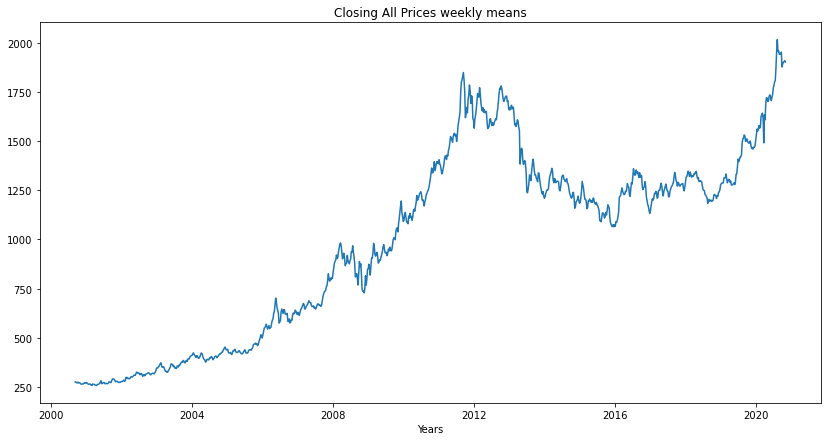

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(w_df)
plt.title('Closing All Prices weekly means')
plt.xlabel('Years')
plt.show();

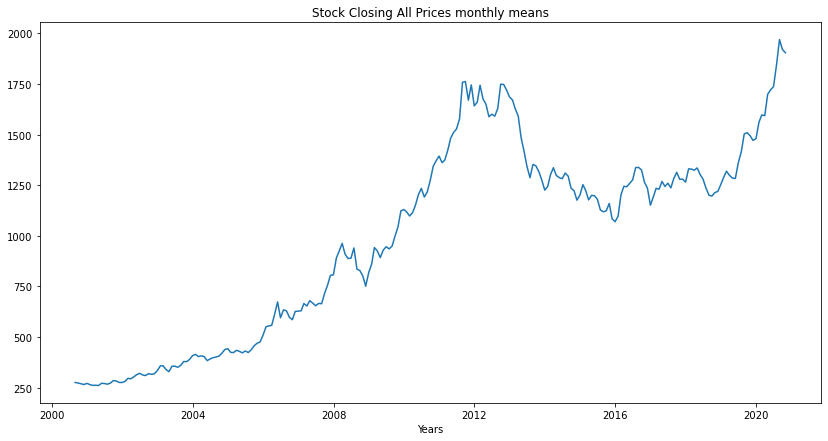

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(m_df)
plt.title('Stock Closing All Prices monthly means')
plt.xlabel('Years')
plt.show();

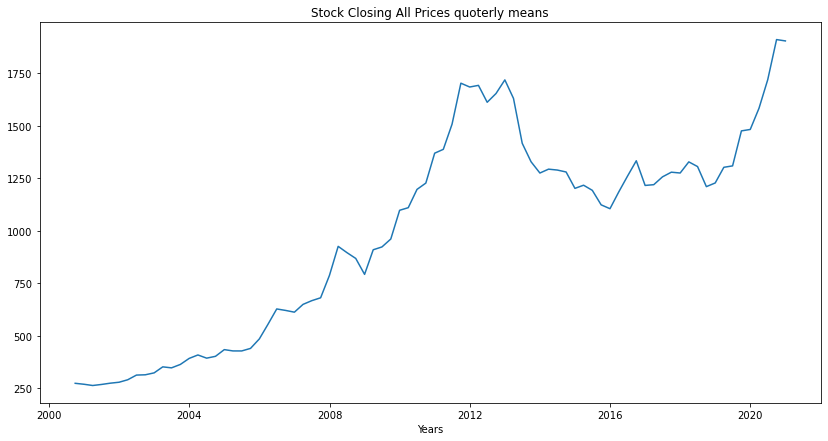

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(q_df)
plt.title('Stock Closing All Prices quoterly means')
plt.xlabel('Years')
plt.show();

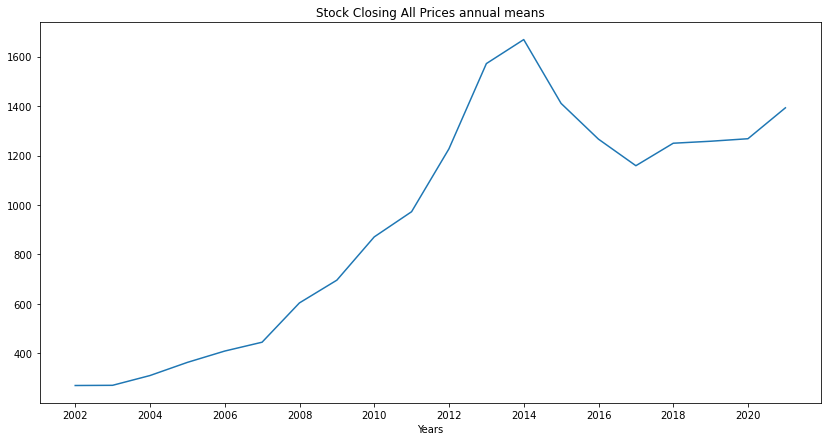

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(y_df)
plt.title('Stock Closing All Prices annual means')
plt.xlabel('Years')
plt.show();

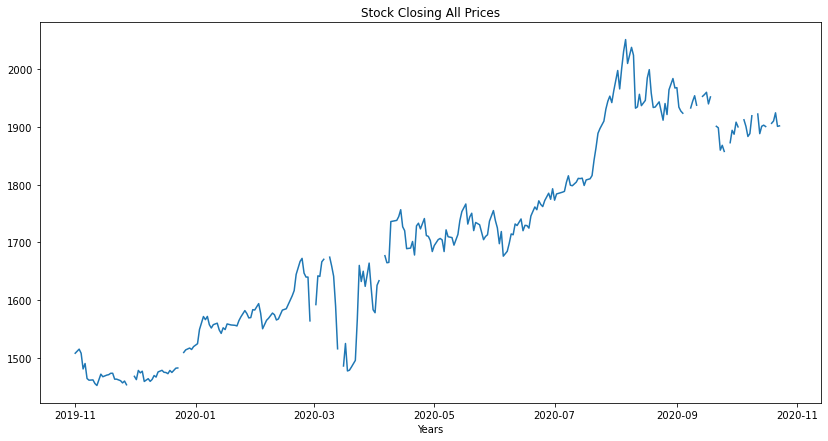

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(data.close[-300:])
plt.title('Stock Closing All Prices')
plt.xlabel('Years')
plt.show();

In [17]:
print(data.shape)
data = data.dropna()
print(data.shape)

(6188, 2)
(5026, 2)


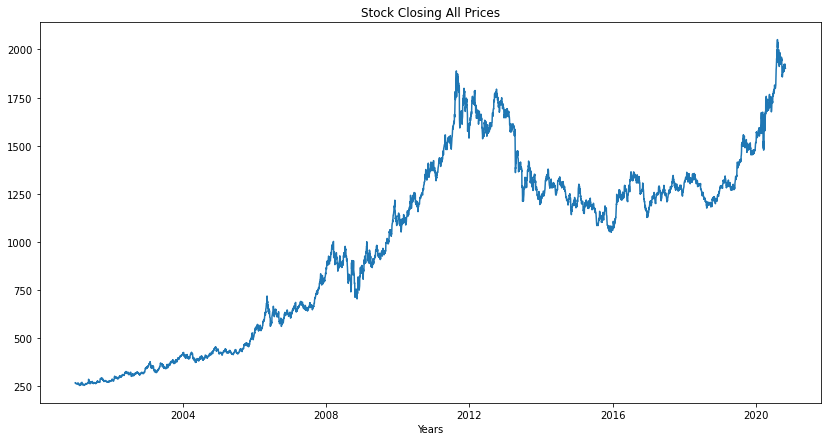

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(data.close)
plt.title('Stock Closing All Prices')
plt.xlabel('Years')
plt.show();

In [19]:
data = data[data.index >= pd.to_datetime('1995-01-01')]

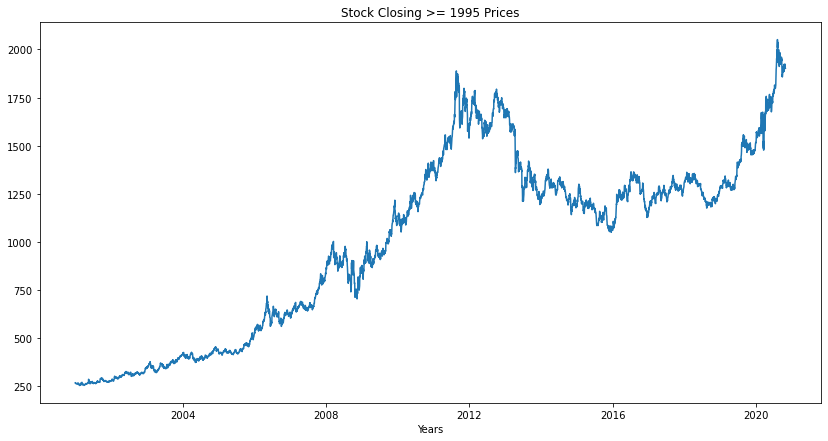

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(data.close)
plt.title('Stock Closing >= 1995 Prices')
plt.xlabel('Years')
plt.show();

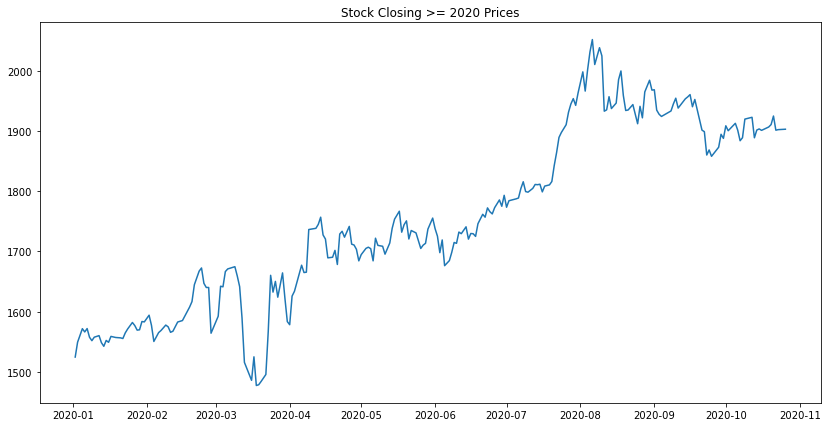

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(data[data.index >= pd.to_datetime('2020-01-01')].close)
plt.title('Stock Closing >= 2020 Prices')
plt.show();

In [22]:
# add column day_of_week

data['day_of_week'] = data.index.dayofweek
data['day_of_week'][:3], data.shape

(date
 2001-01-02    1
 2001-01-03    2
 2001-01-04    3
 Name: day_of_week, dtype: int64,
 (5026, 3))

In [23]:
# one-hot-encoding for day_of_week

data = pd.get_dummies(data, columns=['day_of_week'])
data.shape

(5026, 8)

In [24]:
data.columns

Index(['close', 'prev_year_mean', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_6'],
      dtype='object')

In [25]:
data.index[0], data.index[0+1]

(Timestamp('2001-01-02 00:00:00'), Timestamp('2001-01-03 00:00:00'))

In [26]:
# week, month, quarter number in a year, year (beginning with 0)

data['week_no'] = data.index.week
data['month_no'] = data.index.month
data['quarter_no'] = data.index.quarter
data['year'] = data.index.year

data.head(), data.tail()

(                 close  prev_year_mean  day_of_week_0  day_of_week_1  \
 date                                                                   
 2001-01-02  268.399994      270.280952              0              1   
 2001-01-03  268.000000      270.280952              0              0   
 2001-01-04  267.299988      270.280952              0              0   
 2001-01-05  268.000000      270.280952              0              0   
 2001-01-08  268.000000      270.280952              1              0   
 
             day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_6  \
 date                                                                     
 2001-01-02              0              0              0              0   
 2001-01-03              1              0              0              0   
 2001-01-04              0              1              0              0   
 2001-01-05              0              0              1              0   
 2001-01-08              0           

In [27]:
# might be avoided

data['year'] /= data.index.year.max()    # - data.index.year.min()

In [28]:
# start of month - end of month

data['day_of_month'] = data.index.day
data['month_end_start'] = data['day_of_month'].apply(lambda d: 0
                                                    if d < 9 else
                                                    (1 if d > 22 else 3))
data['month_end_start'].values[:32]

array([0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 3, 3, 3, 3, 3])

In [29]:
data = pd.get_dummies(data, columns=['month_end_start'])

In [30]:
# end-start of quarter: 0 - start, 1 - end, 3 - mid

data['month_in_qrtr'] = data['month_no'].apply(lambda m: 0
                                               if m in (1,4,7,10) else
                                               (1 if m in (3,6,9,12) else 3))

In [31]:
data = pd.get_dummies(data, columns=['month_in_qrtr'])

In [32]:
data = pd.get_dummies(data, columns=['quarter_no'])

# # try to avoid
# data = pd.get_dummies(data, columns=['year'])

data.columns

Index(['close', 'prev_year_mean', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_6',
       'week_no', 'month_no', 'year', 'day_of_month', 'month_end_start_0',
       'month_end_start_1', 'month_end_start_3', 'month_in_qrtr_0',
       'month_in_qrtr_1', 'month_in_qrtr_3', 'quarter_no_1', 'quarter_no_2',
       'quarter_no_3', 'quarter_no_4'],
      dtype='object')

In [33]:
data = data.drop(['week_no', 'day_of_month', 'month_no'], axis=1)
data.shape

(5026, 19)

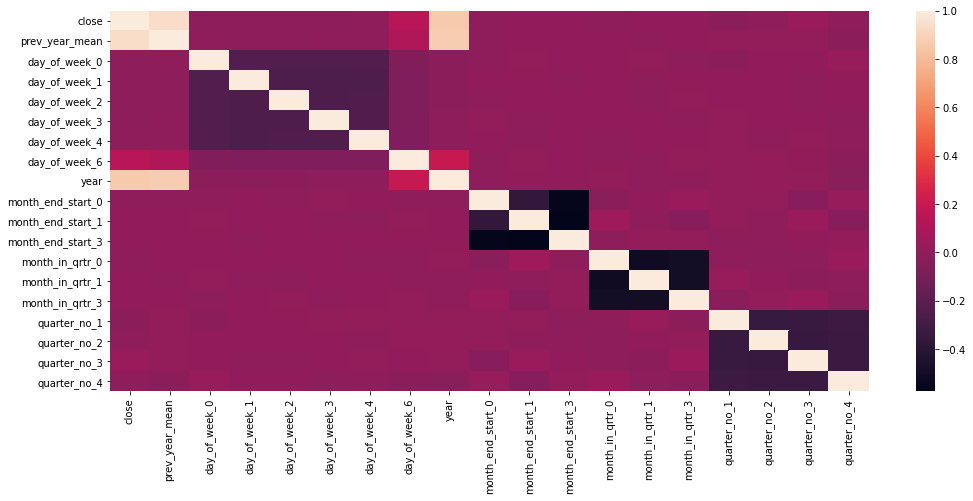

In [34]:
plt.figure(figsize=(17, 7))
sns.heatmap(data.corr());

In [35]:
print(data.shape)
data = data.dropna()
print(data.shape)

(5026, 19)
(5026, 19)


In [36]:
# outliers

data.query('close < 0').shape[0]

0

In [37]:
data = data.query('close > 0')
data.shape

(5026, 19)

In [38]:
X_train = data[data.index < pd.to_datetime('2020-01-01')].drop('close', axis=1)
y_train = data[data.index < pd.to_datetime('2020-01-01')]['close']
X_test = data[data.index >= pd.to_datetime('2020-01-01')].drop('close', axis=1)
y_test = data[data.index >= pd.to_datetime('2020-01-01')]['close']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4788, 18), (4788,), (238, 18), (238,))

In [39]:

fact = data[data.index >= pd.to_datetime('2020-01-01')].close


In [40]:
# XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
preds_xgb = model.predict(X_test)

In [42]:
y_train[-1], preds_xgb[0]

(1519.5, 1248.5842)

In [43]:
preds_xgb_improved = preds_xgb * y_train[-1] / preds_xgb[0]

In [44]:
prediction_xgb = pd.DataFrame({'data': X_test.index, 'close': preds_xgb_improved}).set_index('data')

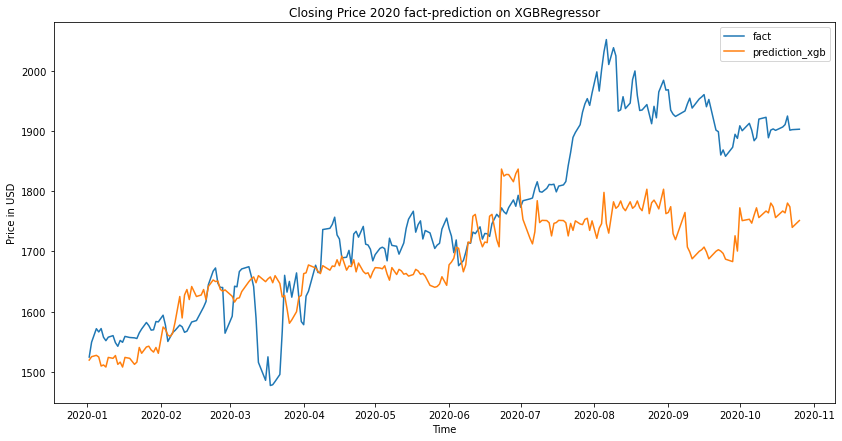

In [45]:
plt.figure(figsize=(14, 7))
plt.plot(fact)
plt.plot(prediction_xgb)
plt.title('Closing Price 2020 fact-prediction on XGBRegressor')
plt.legend(['fact', 'prediction_xgb'])
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.show();

In [46]:
# RandomForestRegressor

regr = RandomForestRegressor(n_estimators=1000, random_state=383).fit(X_train, y_train)

In [47]:
preds_rf = regr.predict(X_test)

In [48]:
y_train[-1], preds_rf[0]

(1519.5, 1289.3653346247881)

In [49]:
preds_rf_improved = preds_rf * y_train[-1] / preds_rf[0]

In [50]:
prediction_rf = pd.DataFrame({'data': X_test.index, 'close': preds_rf_improved}).set_index('data')

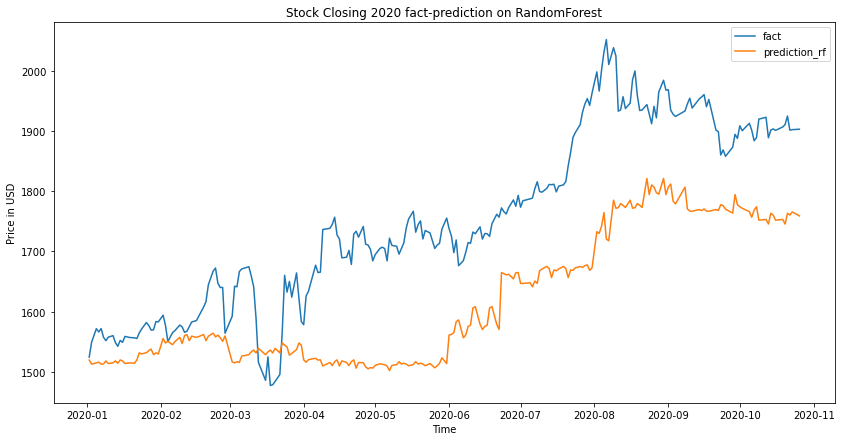

In [51]:
plt.figure(figsize=(14, 7))
plt.plot(fact)
plt.plot(prediction_rf)
plt.title('Stock Closing 2020 fact-prediction on RandomForest')
plt.legend(['fact', 'prediction_rf'])
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.show();

In [52]:
fact.to_csv(stock + '_fact.csv')
prediction_xgb.to_csv(stock + '_prediction_xgb.csv')
prediction_rf.to_csv(stock + '_prediction_rf.csv')

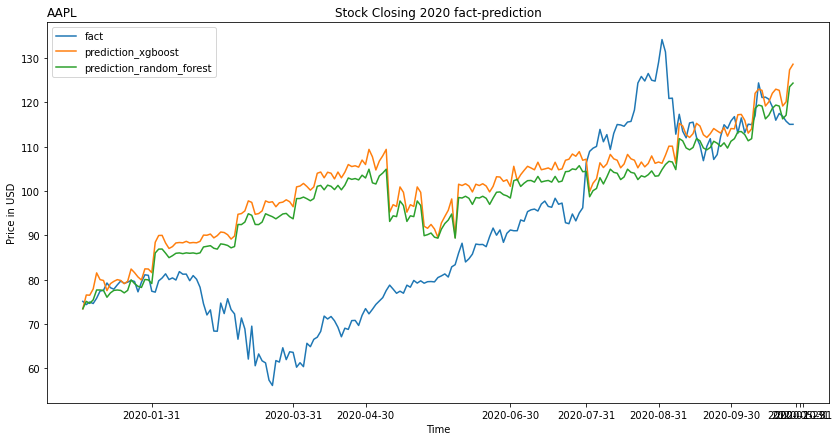

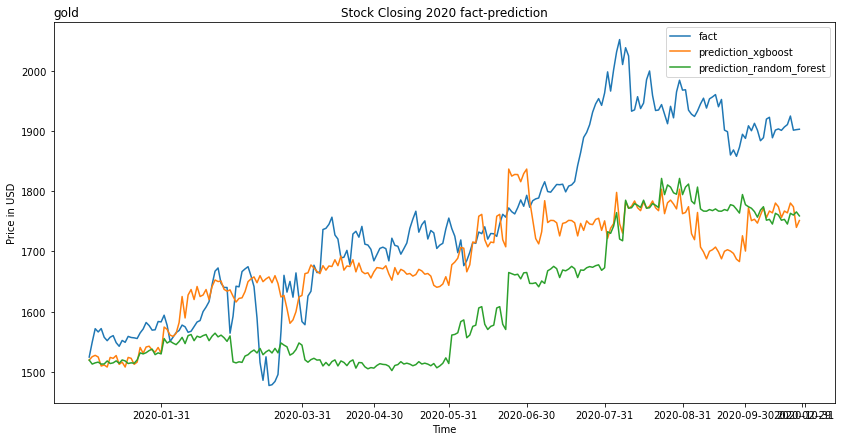

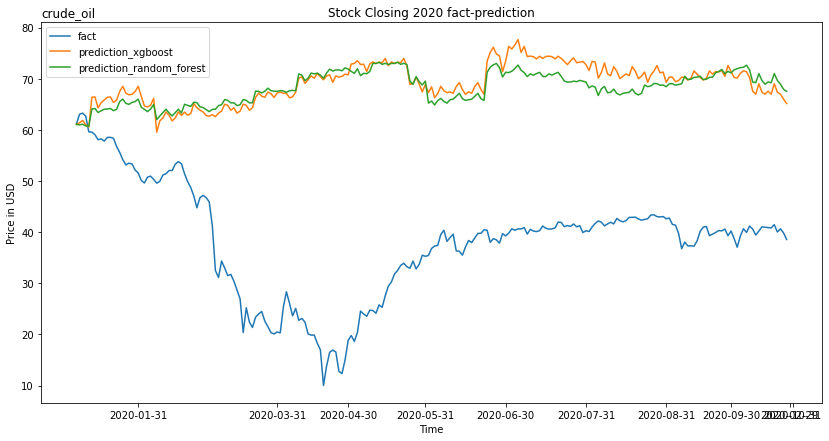

In [53]:
for chip in ['AAPL', 'gold', 'crude_oil']:
    fact = pd.read_csv(chip + '_fact.csv', index_col=0)
    prediction_xgb = pd.read_csv(chip + '_prediction_xgb.csv', index_col=0)
    prediction_rf = pd.read_csv(chip + '_prediction_rf.csv', index_col=0)

    plt.figure(figsize=(14, 7))
    plt.plot(fact)
    plt.plot(prediction_xgb)
    plt.plot(prediction_rf)
    plt.xticks(pd.date_range('2020-01-01', periods=10, freq='M').astype('str'))
    plt.title(chip, loc='left')
    plt.title('Stock Closing 2020 fact-prediction')
    plt.legend(['fact', 'prediction_xgboost', 'prediction_random_forest'])
    plt.xlabel('Time')
    plt.ylabel('Price in USD')
    plt.show();
    